In [3]:
# Import

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import time

In [4]:
# (a) Crop the image and save as PNG
# Open the input image
input_image = Image.open("Lenna.png")

# Get the size of the input image
width, height = input_image.size

# Calculate the coordinates of the center of the image
center_x = width // 2
center_y = height // 2

# Calculate the size of the cropped region
crop_size = min(width, height) // 2

# Calculate the coordinates of the top-left corner of the cropped region
crop_x = center_x - crop_size // 2
crop_y = center_y - crop_size // 2

# Crop the image
cropped_image = input_image.crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size))

# Save the cropped image as a PNG file
cropped_image.save("cropped_image.png", format="PNG")

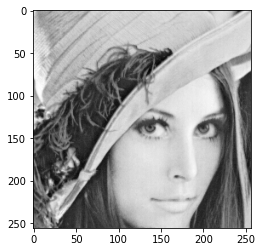

In [5]:
# (b) Extract the red channel of the image and display it
# Convert the cropped image to a NumPy array
cropped_array = np.array(cropped_image)

# Extract the red channel of the cropped image
red_channel = cropped_array[:, :, 0]

# Display the red channel using matplotlib
plt.imshow(red_channel, cmap="gray")
plt.show()


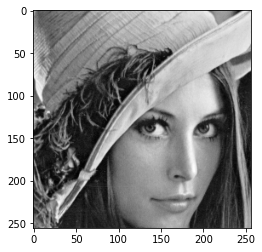

In [6]:
# (c) Convert the image to grayscale and display it
# Convert the cropped image to grayscale
gray_image = cropped_image.convert('L')

# Display the grayscale image using matplotlib
plt.imshow(gray_image, cmap="gray")
plt.show()

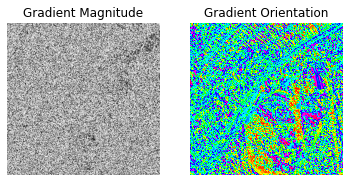

In [7]:
# (d) Apply Sobel filters to the grayscale image and display the results
# Define Sobel filters in x and y directions
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Apply the Sobel filters to the grayscale image
grad_x = ndimage.convolve(gray_image, sobel_x)
grad_y = ndimage.convolve(gray_image, sobel_y)

# Obtain the gradient magnitude and orientation
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_ori = np.arctan2(grad_y, grad_x)

# Display the gradient magnitude and orientation using matplotlib
plt.subplot(121)
plt.imshow(grad_mag, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")
plt.subplot(122)
plt.imshow(grad_ori, cmap="hsv")
plt.title("Gradient Orientation")
plt.axis("off")
plt.show()

C:\Users\u27d41\AppData\Local\Temp\ipykernel_22020\3514151851.py:11: DeprecationWarning: Please use `laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  laplacian_image = ndimage.filters.laplace(blurred_image)


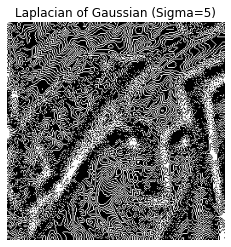

In [8]:
# (e) Obtain Laplacian of Gaussian image for different sigma values and display the results
# Define sigma values for Laplacian of Gaussian
sigmas = [1, 3, 5]

# Apply Laplacian of Gaussian filter to the grayscale image for each sigma value and display the results
for sigma in sigmas:
    # Apply Gaussian blur to the grayscale image
    blurred_image = ndimage.gaussian_filter(gray_image, sigma=sigma)

    # Apply Laplacian filter to the blurred image
    laplacian_image = ndimage.filters.laplace(blurred_image)

    # Display the Laplacian of Gaussian image using matplotlib
    plt.imshow(laplacian_image, cmap="gray")
    plt.title("Laplacian of Gaussian (Sigma={})".format(sigma))
    plt.axis("off")
    plt.show